# Tutorial 4 : Trigger Bias Scan
This tutorial demonstrates a basic performance investigation for the camera using sstcam-simulation, a trigger bias scan.

This is where the trigger threshold is gradually iterated through to explore the how the trigger rate changes. This example is performed with NSB pulses only, and by counting the triggers generated inside a single superpixel (not from the full camera combinatorics).

In [1]:
from sstcam_simulation import Camera, PixelMapping, PhotoelectronSource, EventAcquisition
from sstcam_simulation.camera.spe import PerfectPhotosensor
from sstcam_simulation.event.acquisition import sum_superpixels
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
readout_length = 5 * 1e4  # 50 μs
thresholds = np.linspace(0, 10, 40)  # Units: photoelectron
n_events = 10  # Repeats for statistics
camera = Camera(
    pixel=PixelMapping(n_pixels=4),  # One superpixel
    continuous_readout_length=readout_length,
    coincidence_window=0,
)

In [3]:
def perform_bias_scan(nsb):
    rate = np.zeros((n_events, thresholds.size))
    for iev in range(n_events):
        source = PhotoelectronSource(camera=camera)
        photoelectrons = source.get_nsb(nsb)

        acquisition = EventAcquisition(camera=camera)
        readout = acquisition.get_continuous_readout(photoelectrons)

        for i, thresh in enumerate(thresholds):
            camera.update_trigger_threshold(thresh)
            digital_trigger = acquisition.get_digital_trigger_readout(readout)
            n_triggers = acquisition.get_n_superpixel_triggers(digital_trigger)
            rate[iev, i] = n_triggers / (camera.continuous_readout_length * 1e-9)
    return rate

In [4]:
rate = {f"{nsb} MHz": perform_bias_scan(nsb=nsb) for nsb in [1, 5, 10]}

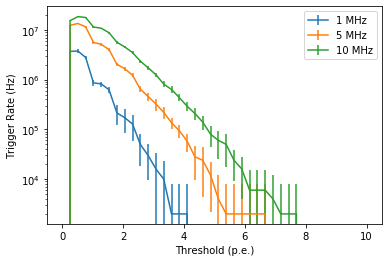

In [5]:
for key, value in rate.items():
    plt.errorbar(thresholds, value.mean(0), yerr=value.std(0), label=key)
plt.legend()
plt.yscale('log')
plt.xlabel("Threshold (p.e.)")
_ = plt.ylabel("Trigger Rate (Hz)")